In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [3]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# A first example of hierarchical  models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html

* Some images are indeed taken  from that book. 

# TODO

* finire simul finale con predizione per artista specifico e per un nuovo artista

# Suggestions from MF, to be checked

* slide 30: fix
	cat_column = spotify['artist'].astype('category')
	categories = list(cat_column.cat.categories)[::-1]

    * idea: I would compare with simple pooint estimate here and there, e.g. spotify.groupby("artist").mean()

    * slide 37: \sigma_mu is not the uncertainty in the location in the global mean. Is the reasoning at slide 39 sound?


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale.  A priori we can expect the average popularity rating to be around 50.


* Higher popularity usually means the song has been played often, especially  recently. 


* Each song is written by an artist; artist are indexed by $j$.


* $Y_{ij}$:  the popularity of the $i$-th song by the $j$-th artist.

# Research questions 


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much might popularity vary from song to song?


*  We look for answers with a quantification of the related uncertainty; hence we use probabilistic models.

In [5]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song, author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


# Hierarchical data set

The data set is hierarchical:

* it comprises  multiple songs for each of 44 artists 
* the artists  were sampled from the population of all artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



In [6]:
# Mean popularity of the songs of each artist.
# There are major differences between authors, both in the number of produced songs and in their  popularity.

artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [7]:
# Number of the songs of each artist, which varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count().sort_values('popularity')
artist_count.head()

,title,popularity
artist,,
Sean Kingston,2,2
David Lee Roth,3,3
Lil Skies,3,3
Tamar Braxton,3,3
Honeywagon,3,3


# The structure of the data
* The $j$ subscript refers to the $j$-th  artist.


*  The $i$ subscript refers to the $i$-th  song, among the songs written by the same artist.


* $n_j$ is  the number of songs of  artist $j$ , $j \in  \{1,2,…,44\}$. 


*  $Y_{ij}$  represents the $i$-th song of artist $j$, where $i \in \{1,2,…,n_j\}$ and $j \in \{1,2,…,44\}$.


* The sample is the collection of 44 smaller samples (*sub-populations* or *clusters*), one for  each artist.

# Three different modelling approaches

* *Pooled*: ignore artists and merge the data from all songs.
     * it  does not model differences between artists
     
     
* *No pooling*:  analyze each artist independently
    * the prediction of an artist which has published very few songs is very uncertain
    * cannot predict a novel artist


* *Partial pooling* via hierarchical model. Model the population of  artists and the population of songs from each artist.
    * each artist has his own  estimated popularity,  but the model shares  information about different artistist
    * this allows to produce sensible predictions also for artist for which there are no songs.

# Pooled model

* The  pooled model ignores the clustering (or *grouping*) structure implied by the different authors.
*  It treats  all songs as a sample from the same population, without modelling the  presence of sub-populations corresponding to the different authors.
* For simplicity,  we assume  the ratings to be normally distributed.

<img src='img/spotify-density.png' width=400 align="center" >

# Pooled model

* We assume the  popularity of every song to be   normally distributed $N(\mu,\sigma)$.  Thus $\mu$ and $\sigma$ are shared by every song; those are  *global* parameters which do not vary by artist.





\begin{align}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(0,\xi)\\
y_{ij} & \sim N(\mu, \sigma) \;\;  \forall i,j 
\end{align}

# Quiz yourself

* What would be the  prediction of the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) ? 
    * Beyoncé, the artist with nearly the highest mean popularity in our sample (70)?
    * Mohsen Beats, a group not present in the sample?




# Answer
* The  complete pooled model ignores the artist-specific information.
* It  predicts the same  popularity for any new song of  every artist, included or not included in the sample.

# The prior on $\mu$

* A priori, we believe $\mu$ to be  around 50; we think that with 95% probability $\mu$ lies in  (10, 90).


* Interpreting this interval as $\mu \pm 2 \sigma$, we set  a standard deviation of (90-50)/2 $\approx$ 20. 

$$ \mu \sim N(50, 20) $$

# The prior on $\sigma$

In [8]:
# Quantifying the prior p(\sigma)
# A priori, we believe a plausible value of  $\sigma$ to be  around 20
# This  would let the popularity vary in the range 50 +- 3*20 (-10 , 110), slightly in excess of the allowed range 0-100.

from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


# The pooled model


\begin{align*}
\mu    & \sim N(50, 20) \\
\sigma & \sim\text{HalfNormal} (30) \\
y_{ij} | \mu, \sigma & \sim N(\mu, \sigma) \\
\end{align*}

In [11]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  20)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [12]:
# The posterior summary shows  that Spotify songs have an average popularity of about 58; 
# there is  a relatively large standard deviation from song to song (global_sigma) of about 20 points.
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.361,1.125,56.337,60.489,0.020,0.014,3228.0,2946.0,1.0
global_sigma,20.728,0.749,19.446,22.237,0.013,0.009,3448.0,3052.0,1.0


# Prediction the popularity of the next song

* The prediction is the same for any artist.



* The trace contains some thousands (e.g., 4000) parameter samples  $<\mu_s, \sigma_is>$. 



* The probabilistic prediction for the next observation is computed  by drawing  a simulated value from each sample:

$$
y_{\text{new}}^{s} | \mu_s, \sigma_s \; \sim \; N\left(\mu_s, \sigma_s\right)\;\; i=1,2...4000$$



# Posterior prediction

* Each parameter set  $<\mu_i, \sigma_i >$  yields a different prediction:

$$
\left[
\begin{array}{ll} 
\mu^{(1)} &   \sigma^{(1)} \\
\mu^{(2)} & \sigma^{(2)} \\
\vdots & \vdots  \\
\mu^{(4000)}  & \sigma^{(4000)} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
Y_{\text{new}}^{(1)} \\
Y_{\text{new}}^{(2)} \\
\vdots \\
Y_{\text{new}}^{(4000)} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for two sources of uncertainty:

   * uncertainty in the estimation of $\mu, \sigma$
   * uncertainty in the realization of the noise.

# Computing the posterior prediction within the model code

In [13]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  13)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    #prediction
    prediction          =  pm.Normal('prediction', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prediction, global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [20]:


#with pooled_model:
    # this function sets the test data (structured as a dict) in correspondence of which to compute the prediction.
    # But our model has no feature, hence the list of test values is empty. We make a predition on popularity using its posterior distribution.
    # In this way we account for our uncertainty on the estimate of the parameters.
#    pm.set_data({})
    # the posterior_predictive function implements the probabilistic prediction of the previous slide#    y_test = pm.sample_posterior_predictive(trace_pooled, samples=1000)

az.summary(trace_pooled, var_names='prediction')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,58.162,21.422,17.316,97.033,0.288,0.215,5518.0,2783.0,1.0


# Unpooled model

* This model independently analyzes the popularity of each artist.


* The $j$-th artist has its own mean popularity $\mu_j$.



* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.


* One artist’s mean doesn’t tell us anything about another’s.


* We assume that  $\sigma$ is common to all artist and thus it lacks the  $j$ subscript.


* That simplies the sampling, but it could be  worth implementing a  variant with a specific $\sigma$ for each artist and comparing the two models.
   

# Unpooled model

   * $\mu_j$ = mean song popularity for artist $j$
   * $\sigma$:  standard deviation of popularity from song to song within each artist.


<img src='img/spotify-unpooled.png' width=400 align="center" >

# Unpooled model

* The priors are the same of the pooled model. But every $\mu_j$ is now an independent parameter.

\begin{align*}
\mu_j    & \sim N(50, 20) \\
\sigma & \sim \text{HalfNormal}(30) \\
Y_{ij} | \mu_j, s_{\mu} & \sim N(\mu_j, \sigma^2) \\
\end{align*}

In [14]:
n_artist = len(artist_count) #44

#array of string with the name
artist       = spotify['artist'].values

#assign a numerical code to each author.
#maps the first author to 0, the second author to 1, etc.
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes
spotify['artist_code']

0       0
1       0
2       0
3       0
4       0
       ..
345    43
346    43
347    43
348    43
349    43
Name: artist_code, Length: 350, dtype: int8

In [18]:
n_artist = len(artist_count) #44

with pm.Model() as unpooled_model:
    # We have a vector of means, one for each artist, each with the same prior; each one is  updated into a posterior independently from the others.
    mean            =  pm.Normal ('mean', 50,  20, shape= n_artist)
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood. A different mean for  each artist is inferred 
    popularity      =  pm.Normal ('popularity', mu = mean[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [16]:
# one mean for each artisti
az.summary(trace_unpooled).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean[0],63.955,3.031,58.482,69.733,0.031,0.022,9347.0,3011.0,1.0
mean[1],46.603,6.241,34.883,58.561,0.062,0.044,10190.0,2623.0,1.0
mean[2],58.743,5.536,48.217,68.999,0.053,0.038,10944.0,3196.0,1.0
mean[3],44.403,6.763,32.129,57.441,0.068,0.049,9735.0,2959.0,1.0
mean[4],68.894,2.883,63.546,74.327,0.028,0.020,10378.0,2413.0,1.0


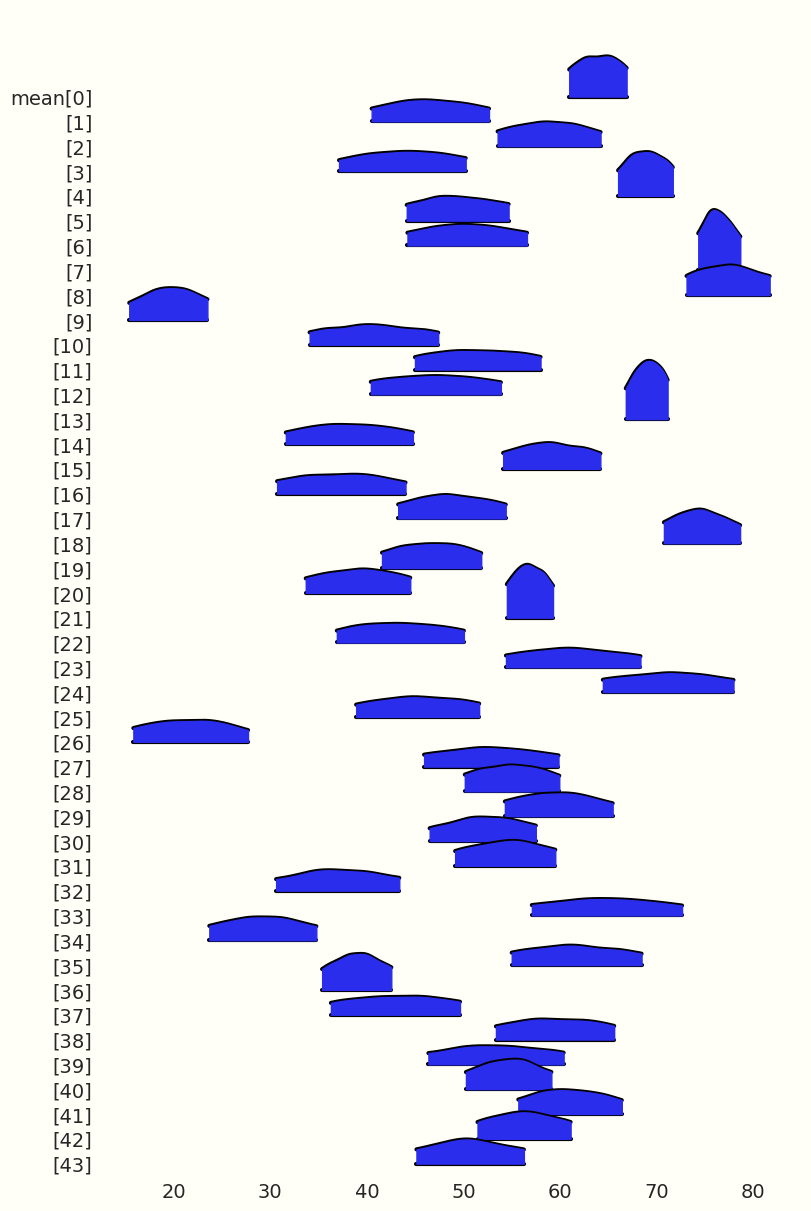

In [17]:
#graph could be refined setting labels on the y axis, as in https://arviz-devs.github.io/arviz/user_guide/label_guide.html
axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.68, var_names="mean", combined=True, figsize=(8,12));

# Discussion

* The no pooled allows some artists to be more popular than others.



* Yet, it  does not model the *population* of  artists. Even though we have analyzed 44 artist, it is unable to say anything about a novel artist not yet present in the sample.



* Some estimates   are also problematic as even the 68% prediction interval is rather large; those are artist with few published songs.


* For example, our low posterior predictions for Mia X’s next song were based on a measly 4 songs. The other artists’ data suggests that these low ratings might just be a tough break – her next song might be more popular! Similarly, our high posterior predictions for Lil Skies’ next song were based on only 3 songs. In light of the other artists’ data, we might wonder whether this was beginner’s luck that will be tough to maintain.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} y_{ij} | \mu_j, \sigma_y   & \hspace{-0.075in} \sim \text{model of how song popularity varies WITHIN artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j | \mu, \sigma_\mu & \hspace{-0.075in} \sim \text{model of how the typical popularity $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \sim \text{prior models for shared global parameters} \\
\end{array}
\end{equation}

# Level 1: individual songs for each artist.

* For  artist $j$, we assume that the popularity of songs $i$ is normally distributed with mean $μ_j$ and standard deviation $σ_y$
* The shared $σ_y$, which is common among all artists, simplifies the sampling of the model; an alternative parameterization with a different $\sigma_j$ for each artist could be also implemented however.
$$  Y_{ij} \sim N(\mu_j, \sigma_y) $$

# Level 2: modeling the population of artists

* If we  place separate priors on each $\mu_j$, we obtain the no-pooled model.
* Layer 2 is where the hierarchical model is different. 
* Layer 2 acknowledges that the 44 sampled artists are  drawn from the same population of Spotify artists. 
* Within this population, popularity varies from artist to artist.
* Yet, we can consider the  $μ_j$ as sampled from the population of the mean popularity of artists:
$$ \mu_j \sim N(\mu, \sigma_{\mu}) $$

# Level 2: modeling the population of artists

$$ \mu_j \sim N(\mu, \sigma_{\mu}) $$

* $\mu$ :  global average of mean popularities within the population of artists
* $\sigma_\mu$ :  standard deviation in mean popularity μj from artist to artist.

# Notation alert

* Notice the  difference between $μ_j$ (mean of the j-th artist) and $\mu$ (mean of the population of artists).

* When a parameter has a subscript $j$, it refers to a group $j$; when it has no subscript, it is global, i.e., it refers to  the whole population of artists.

* $\sigma_y$ refers to the standard deviation of $Y$ values within each group. 
* $\sigma_{\mu}$ refers to the standard deviation of the means $\mu_j$ within the population of artists.

# Level 3: priors for the global parameters $\mu, \sigma_{\mu}, \sigma_y$

\begin{align*}
\mu           & \sim N(50, 20) & \text{(implies a range of +- 60 around 50)} \\
\sigma_y      & \sim \text{Half Normal}(15) & \text{(discussed in next slide)}     & \\
\sigma_\mu & \sim \text{Half Normal}(6)    & \text{(uncertainty in the location of the global mean)}  \\
\end{align*}

In [13]:
# how to choose the priors on sigma_y
# assume that the popularity of the songs of a  given artist (sigma_y) span a range of about 50 point
# 50 / 3 is around 17, which is a plausible though large value of sigma.
# We make sure that our half normal prior covers values which are also quite far from this guess.
# To check that our prior is sensible, we sample 10000 values from the prior and checks the distribution.
# Below we implement the halfNormal as the abs of random normal.

pd.DataFrame(np.abs(np.random.normal(0, scale=15, size=10000))).describe()

,0
count,10000.000000
mean,12.033872
std,9.111312
min,0.000686
25%,4.731771
50%,10.219122
75%,17.488047
max,55.195757


In [14]:
# how to choose the priors on sigma_mu
# We assume the mean popularity to lie in a region of +- 20 points around 50.
# Thus the interval of 3 sigma should be around 20, that is sigma about 7.
# As a cross-check the mean popularity in the sample is indeed 58.
# A possible choice is given below
pd.DataFrame(np.abs(np.random.normal(0, scale=6, size=10000))).describe(percentiles=[0.50, 0.75, 0.95])

,0
count,10000.000000
mean,4.759896
std,3.590454
min,0.000412
50%,4.034635
75%,6.885463
95%,11.718702
max,21.718400


In [19]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity, within the population of artists
    # Popularity lies between 0 and 100. We thus assume it to be a Beta variable multiplied by 100.
    mu_proportion    = pm.Beta ('mu_proportion',alpha=2, beta=2)
    mu = pm.Deterministic('mu',mu_proportion * 100)
    
    # alternative parameterization, which does not bound mu in [0,100]
    #   mu   = pm.Normal ('mu', 50,  20)

    sigma          = pm.HalfNormal ('sigma', 15)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    
    # layer 2: model of the population of artists.
    mean       =  pm.Normal ('mean', mu,  sigma_mu, shape= n_artist)
    sigma_y   = pm.HalfNormal ('sigma_y', sd = sigma)

    #layer 3 (observation specific for each artist)
    popularity      =  pm.Normal ('popularity', mu = mean[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    trace_hier  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, mean, sigma_mu, sigma, mu_proportion]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


# Conceptual exercise: modelling fuel prices

* Define a hierarchical model for the fuel price
    * based on a set of  $n_{\text{station}}$ stations. The price at each station varies depending on its location, offered services, and so on. You want thus to model  how the price varies within the population of gas stations.
    * the model should account also for the  variation  of price that might occur during a month at the same gas station. Thus $Y_{ij}$ is the price of gas at the $j$-th station in the $i$-th day.
*   Interpret the meaning of all model coefficients in terms of what they practically mean ( $\mu_j$, $\sigma_y$, $\mu$, $\sigma_mu$).
* Write the model formuals, providing sensible priors based on your experience.
*  Consider  a monopolistic scenario in which all the gas station are run by the same company. Thus the price change on a daily basis, but at given time  all gas station provide the  same price. How would you change the model?   

    

# Parameters
* The hierarchical Spotify model  has  47 parameters:
    * 44 artist-specific parameters $\mu_j$
    * 3 global parameters $\mu, \sigma_y,  \sigma_\mu\$.

In [16]:
az.summary(trace_hier)[ ["mean","hdi_3%","hdi_97%","r_hat"]]

,mean,hdi_3%,hdi_97%,r_hat
mean[0],64.201,58.550,70.233,1.00
mean[1],47.169,36.410,59.449,1.00
mean[2],59.377,48.312,70.445,1.00
mean[3],44.960,32.234,58.113,1.00
mean[4],69.039,64.140,74.489,1.00
mean[5],49.654,39.308,59.514,1.00
mean[6],50.917,38.854,62.983,1.00
mean[7],76.451,72.114,80.856,1.01
mean[8],78.003,69.876,86.740,1.00
mean[9],19.713,12.018,28.192,1.00


In [17]:

#we analyze the model step by step
# there is about 95% probability of the mean popularity of an artist being between about 48 and 57
az.summary(trace_hier, var_names="mu")[ ["mean","hdi_3%","hdi_97%","r_hat"]]

,mean,hdi_3%,hdi_97%,r_hat
mu,52.451,48.186,57.175,1.0


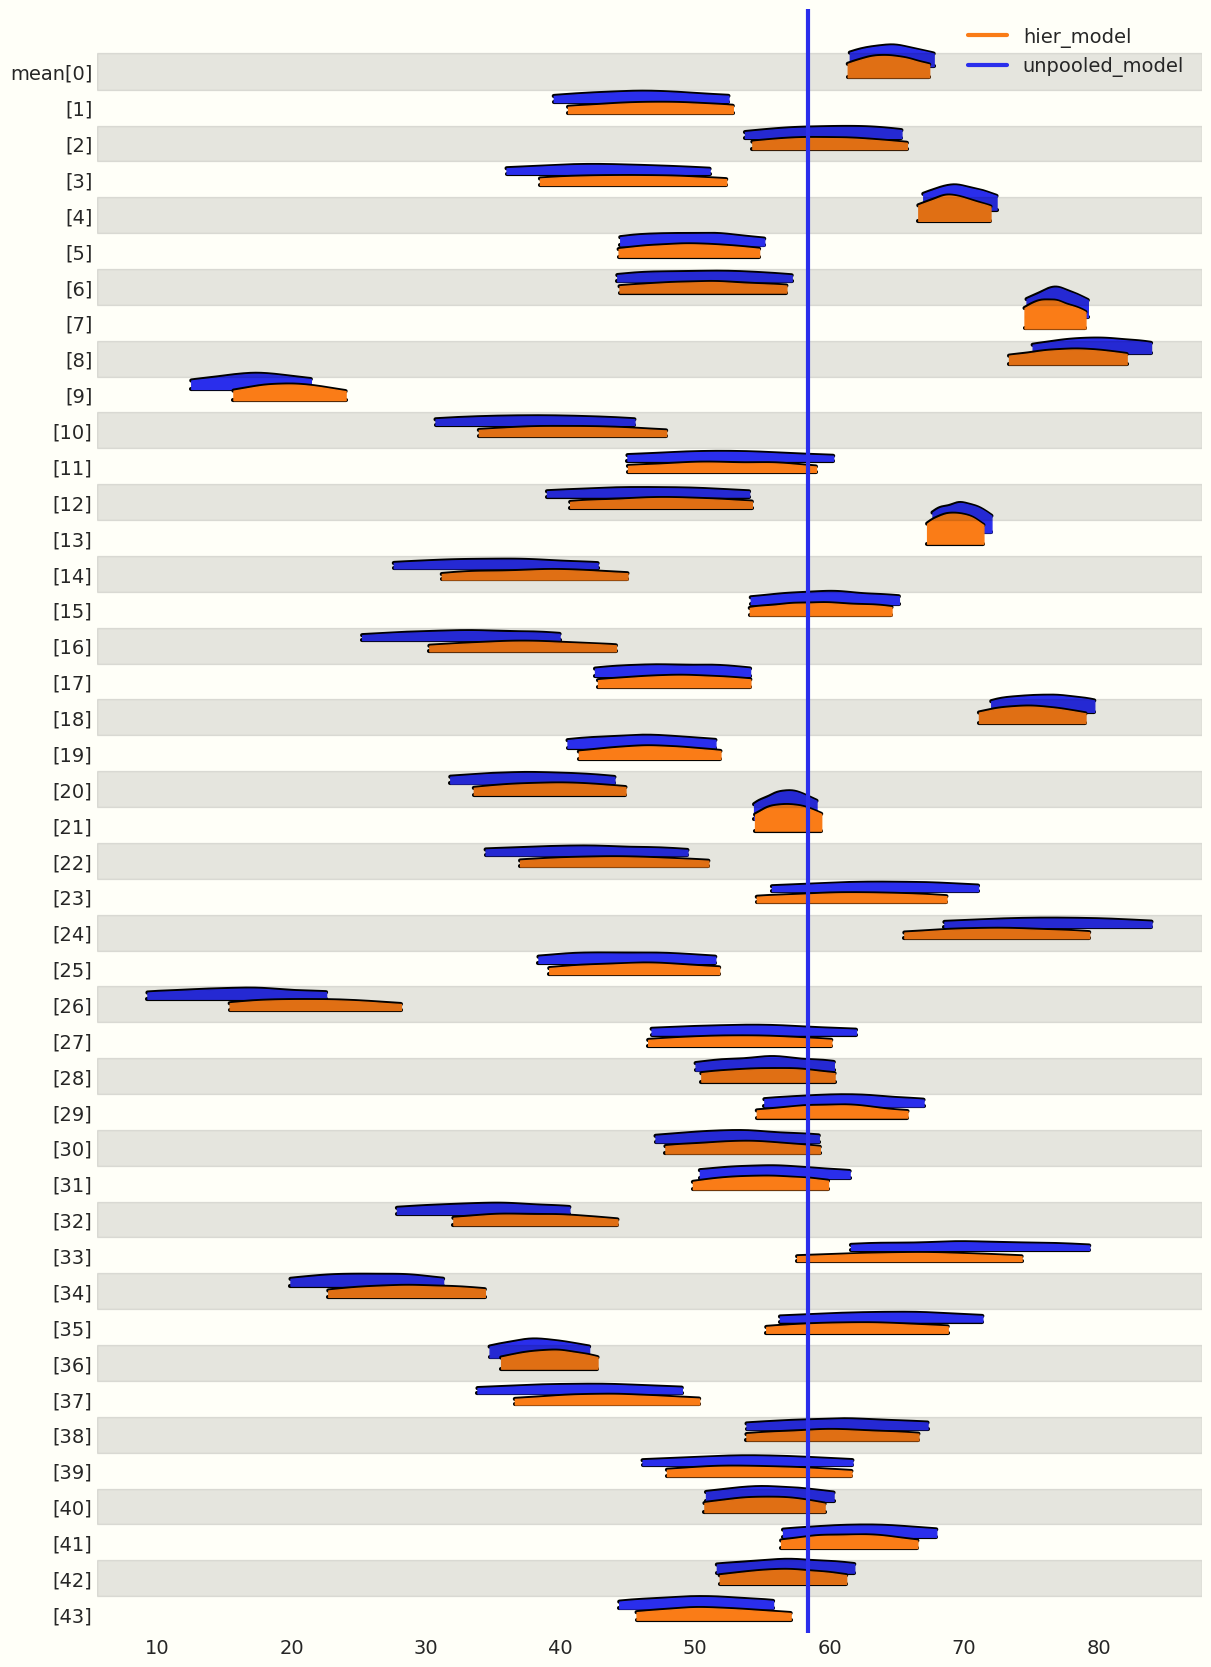

In [18]:
#plotting the estimated popularity of each artist, according to the unpooled and to the hierarhical model
# in a more refined implementation it would be nice to show the artist name on the y axis
# to have a more readable plot, we use a rather short 68% hdi, corresponding to +-1sigma around the mean
axes = az.plot_forest([trace_unpooled, trace_hier], 
                      model_names=['unpooled_model', 'hier_model'], combined=True, kind='ridgeplot', var_names='mean', hdi_prob=0.68);

#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

#plt.savefig('shrinkage.png')

# Shrinkage: pulling the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist;  the  posterior mean popularity was the same for each artist, which is roughly equivalent to the grand mean (i.e., the mean popularity of the 350 songs)


*  The unpooled model separately analyzes each artist;  its predictive means are roughly equivalent to the sample mean popularity of  each artist.


* In both cases, the estimates are regularized by the prior, hence they are not truly identical to the sample means


* The hierarchical models is a more sophisticated approach. It pulls  (or *shrunk*) the predictions of the unpooled model  toward the global trends of the pooled model.


# Shrinkage

* Under  simplifying assumptions, we can approximate the posterior mean of artist $j$  as: 

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu}
}_{\text{weight of the global model}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu}
}_{\text{weight of the local model}}
\overline{y}_j
$$


* The weight of   local model increases when we have more data ($n_j$) about artist $j$.
* The weights also depend on $\sigma_y$: the larger $\sigma_y$ and hence the variability of popularity for the same artist, the larger the weight of the global model (we cannot trust much the means  $\overline{y}_j$).

* Scenarios in which the hierarchical posterior predictions shrinks towards the global mean:
     * when  $n_j$ is low:  we rely more on global trends to understand a group for which we have little data.
     *  when the variability of popularity for songs of the same artist ($\sigma_y$) is large in comparison to the variability the mean populatrity of the artists $\sigma_{\mu}$.
     * If the models learns that  artist are very similar to each other ($\sigma_{\mu}$ is low), it increases the weight of the pooled model.

In [61]:
# NON FUNZIONA, CHIDERE A MARCO. VORREI MOSTRARE INTENSITA DELLO SHRINKAGE IN FUNZIONE DI NJ

# measuring shrinkage as a function of $n_j$

n_j=spotify['artist'].value_counts(sort=False)


#posterior mean according to the unpooled model
mean_unpooled = pd.Series(az.summary(trace_unpooled, var_names='mean')["mean"], index=n_j.index)

#posterior mean according to the hier model
mean_hier = az.summary(trace_hier, var_names='mean')["mean"]

shrinkage= pd.Series (mean_hier-mean_unpooled, index=n_j.index)

type(n_j)
#df= pd.concat([mean_unpooled - mean_hier, n_j])


pandas.core.series.Series

# Discussion

* Consider the complete pooled model. By pooling all cases together, this model is very rigid and won’t vary much if based on a different sample of Spotify artists. BUT it also tends to be overly simple and miss the nuances in artists’ mean popularity  Thus, complete pooled models tend to have higher bias and lower variance.


* No pooled models have the opposite problem. With the built-in flexibility to detect group-specific trends, they tend to have less bias than complete pooled models. BUT, since they’re tailored to the artists in our sample, if we sampled a different set of Spotify artists our no pooled models could change quite a bit, and thus produce unstable conclusions. Thus, no pooled models tend to have lower bias and higher variance.


* Hierarchical models offer a balanced alternative. Unlike complete pooled models, hierarchical models take group-specific trends into account, and thus will be less biased. And unlike no pooled models, hierarchical models take global trends into account, and thus will be less variable. Hierarchical models!

# Grouping variable or covariate?

* Suppose our dataset includes a categorical variable  for which we have multiple observations per category. 
* To determine whether $X$ encodes some grouping structure to be hierarchically modeled or it is a potential covariate of the regression model:

*   if the observed data on $X$ covers all categories of interest, it’s likely  to be  better treated as a covariate
* If the observed categories are merely a random sample from many of interest, it is a potential grouping variable.

* Our data set includes only  44 among thousands of artists on Spotify. Hence, treating artist as a predictor (as in the no pooled model) would limit our understanding to only this small number artists.
* In contrast, treating it as a grouping variable (as in the hierarchical model) allows us to not only learn about the 44 artists in our data, but the broader population of artists from which they were sampled.


# Grouping variable or covariate?

* Consider a bike-sharing data set referring to 500 days; for each day we know whether it was a weekday or a weekend.

* Is the weekend variable better modelled as a potential grouping variable or as a covariate?

    * There are only two possible categories: weekend and weekday.
    * The dataset covers both instances.
    * Hence we treat it as a covariate within the model

# Grouping variable or covariate?

* Consider a data set containing math scores  from a sample of 10 Swiss primary schools. 
* We thus have multiple students for each `school_id`.
* These 10 schools are merely a small sample from the hundreds  of Swiss primary schools.
    * The `school_id`, treated as a covariate (unpooled model) would only allow us to learn about our small sample of schools.
    * Treating it as a grouping variable in a hierarchical model  would allow us to extend our conclusions to the broader population of all schools.

# Grouping variable or covariate

* In some cases the decision is not clear-cut. For instance you might have a categorical variable with different levels; for some of them many observations are available, for some other levels the number of observations is reduced.

* In this case you might fit both models, and eventually choose according to WAIC.

* WAIC is a model selection criterion, to be discussed more in detail later. For the moment, it is enough to know that we choose we model with lowest WAIC.

In [72]:
#computing waic of the models fitted so far
# Returns ax DataFrame, ordered from best to worst model.
az.compare({'hierarchical': trace_hier, 'unpooled': trace_unpooled, 'pooled':trace_pooled}, ic='waic')[ ["rank", "waic" ]]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic
hierarchical,0,-1437.210550
unpooled,1,-1437.260889
pooled,2,-1557.671877


# Probabilistic prediction  for the popularity of the next song produced by a specific artist.

Let us denote by $ \mu_{41,s}$ the $s$-th posterior value of the mean popularity of artist $j$ 
`for` $s$ in posterior_samples:
by cycling over the values of $\mu_{41,s}$ we express our uncertainty in the estimate of $\mu_{41,s}$

*  $\mu_{current} = \mu_{41,s}  = \mu_{41,s}$

the song popularity is modelled as the mean of the artist plus noise. The noise has variance $\sigma_y$.


*  You have to generate many samples, every time sampling from $N(\mu_{j,s}, \sigma_{y,s})$.

# Probabilistic prediction  for the popularity of the first song produced by  a novel artist

* As our data set contains 44 artists, the novel artist has index 45. We have no information about him but we know the population of artists.
* We need first to sample plausible values of $\mu_{45}$ from the population of artists, that is from $N(\mu, \sigma_{mu})$.
* However,  there is uncertainty in our estimates of  $\mu$ and $\sigma_{mu}$ that we shall take into account.

Recall the model structure:

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} Y_{ij} | \mu_j, \sigma_y   & \hspace{-0.075in} \sim \text{model of how song popularity varies WITHIN artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j | \mu, \sigma_\mu & \hspace{-0.075in} \sim \text{model of how the typical popularity $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \sim \text{prior models for shared global parameters} \\
\end{array}
\end{equation}

* Let us denote by $S$ the total number of posterior samples. 
1. Draw samples for the possible location of $\mu_{45}$
    * for each sample $s  (s \in 1, ...S)$ 
         * compute  100 times  $\mu_{45,s} \sim N (\mu_s, \sigma_s)$. 
    * from each sample $s$,  we thus obtain a  vector of samples. The vector shows possibile realizations if $\mu_s, \sigma_s$ were the actual parameters of the population of artists.
 
 *    
  
* TO BE IMPLEMENTED

In [28]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity, within the population of artists
    # Popularity lies between 0 and 100. We thus assume it to be a Beta variable multiplied by 100.
    mu_proportion    = pm.Beta ('mu_proportion',alpha=2, beta=2)
    mu = pm.Deterministic('mu',mu_proportion * 100)
    

    # alternative parameterization, which does not bound mu in [0,100]
    #   mu   = pm.Normal ('mu', 50,  20)

    sigma          = pm.HalfNormal ('sigma', 15)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    
    # layer 2: model of the population of artists.
    mean       =  pm.Normal ('mean', mu,  sigma_mu, shape= n_artist)
    sigma_y   = pm.HalfNormal ('sigma_y', sd = sigma)

    #layer 3 (observation specific for each artist)
    popularity      =  pm.Normal ('popularity', mu = mean[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    #prediction of popularity for the next song of  artist 25
    prediction_artist25 = pm.Normal('popularity', mu = mean[25],  sigma = sigma_y)
    
    #prediction of a novel artist
    prediction_artist25 = pm.Normal('popularity', mu = mean[25],  sigma = sigma_y)


    
    
    trace_hier  = pm.sample(return_inferencedata=True)

ValueError: Variable name popularity already exists.

# self quiz: prevedere un artista non ancora a catalogo

In [90]:
#with hier_model:
    #probabilistic prediction 
    # DOES NOT WORK IF I TRY TO SET THE VAR NAMES
    # FARE ANCHE IMPLEMENTAZIONE MANUALE?? O CHIEDERE AGLI STUDENTI DI FARLA
  #  samples =  pm.sampling.sample_posterior_predictive(trace_hier,)
    


In [86]:
az.summary(samples)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (350). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
popularity,58.375,20.54,18.636,95.827,0.047,0.045,155421.0,446727.0,1.04


In [79]:
az.summary(mu_41)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (350). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
popularity,58.382,20.549,18.702,95.926,0.047,0.045,155599.0,446386.0,1.04
